<a href="https://colab.research.google.com/github/xiscoding/langchain_hub/blob/main/visualizeData_multi_agent_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Dataset agentGraph
Goal: Develope system that allows user to input data and have the system develope multiple visualizations of the data until the user is satisfied.

1. Chart Generator Node
2. Data Analysist Node
3. tool calling node
4. Router
5. Human feedback/ usernode

Inspired by initial multi-agent-colabaration guide: https://colab.research.google.com/drive/1XXJsytKOVP7CsgjUy51ddES3jXRzgGt-#scrollTo=743c19df-6da9-4d1e-b2d2-ea40080b9fdc<br>
From youtube langchain: https://www.youtube.com/watch?v=hvAPnpSfSGo

## Set up environment, keys, imports, ect


In [ ]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [ ]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

Please provide your OPENAI_API_KEY··········
Please provide your LANGCHAIN_API_KEY··········
Please provide your TAVILY_API_KEY··········


In [ ]:
# prompt: set "TAVILY_API_KEY"

!echo "export TAVILY_API_KEY='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'" >> ~/.bashrc


## Create agent helper functions

In [ ]:
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " ask the user for confirmation (use the human_tool)."
                " If the user responds FINISH. Prefix your response with FINAL ANSWER."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

## Define Tools

**search, python_repl, humanfeedback**

humanAsATool: https://python.langchain.com/v0.1/docs/integrations/tools/human_tools/

In [ ]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [ ]:
# """Tool for asking human input."""

# from typing import Callable, Optional,Type

# from langchain_core.callbacks import CallbackManagerForToolRun
# from langchain_core.pydantic_v1 import Field
# from langchain_core.tools import BaseTool


# def _print_func(text: str) -> None:
#     print("\n")  # noqa: T201
#     print(text)  # noqa: T201


# class HumanInputRun(BaseTool):
#     """Tool that asks user for input."""

#     name: str = "human"
#     description: str = (
#         "You can ask a human for guidance when you think you "
#         "got stuck or you are not sure what to do next. "
#         "The input should be a question for the human."
#     )
#     prompt_func: Callable[[str], None] = Field(default_factory=lambda: _print_func)
#     input_func: Callable = Field(default_factory=lambda: input)
#     args_schema: Type[BaseModel] = HumanInput
#     def _run(
#         self,
#         query: str,
#         run_manager: Optional[CallbackManagerForToolRun] = None,
#     ) -> str:
#         query = __arg1
#         """Use the Human input tool."""
#         self.prompt_func(query)
#         return self.input_func()

In [ ]:
from langchain.pydantic_v1 import BaseModel, Field

class HumanInput(BaseModel):
    query: str = Field(description="should be a query")

In [ ]:
from langchain_community.tools import HumanInputRun
# humanAsATool
human_tool_desc = '''
You can use this tool to ask the user for the details related to the request.
Always use this tool if you have follow-up questions.
Be concise, polite and professional when asking the questions.
Args:
  query: Question to ask user
'''

def get_input():
    print("Insert your text. Enter 'q' or press Ctrl-D (or Ctrl-Z on Windows) to end.")
    contents = []
    while True:
        try:
            line = input()
        except EOFError:
            break
        if line == "q":
            break
        contents.append(line)
    return "\n".join(contents)


human_tool = HumanInputRun(input_func=get_input, description=human_tool_desc, args_schema=HumanInput)

In [ ]:
human_tool.description

'\nYou can use this tool to ask the user for the details related to the request. \nAlways use this tool if you have follow-up questions. \nBe concise, polite and professional when asking the questions.\nArgs: \n  query: Question to ask user\n'

In [ ]:
human_tool.args

{'query': {'title': 'Query',
  'description': 'should be a query',
  'type': 'string'}}

### HUMAN APPROVAL
Instead of human-as-a-tool, add 'interrupt' and create function to accept input

* Interrupt: https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.MessageGraph.compile
* * https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/#part-3-conditional-interrupt
* * https://blog.langchain.dev/human-in-the-loop-with-opengpts-and-langgraph/
* Human in the loop: https://github.com/langchain-ai/langgraph/blob/main/examples/human-in-the-loop.ipynb?ref=blog.langchain.dev
* https://www.youtube.com/watch?v=9H4gwJGgvfg&list=PLfaIDFEXuae16n2TWUkKq5PgJ0w6Pkwtg&index=4

In [ ]:
from langchain_core.messages import AIMessage
from langchain_core.runnables import Runnable, RunnablePassthrough
from langchain_core.tools import tool
import json

def human_approval(msg: AIMessage) -> Runnable:
    tool_strs = "\n\n".join(
        json.dumps(tool_call, indent=2) for tool_call in msg.tool_calls
    )
    input_msg = (
        f"Do you approve of the following tool invocations\n\n{tool_strs}\n\n"
        "Anything except 'Y'/'Yes' (case-insensitive) will be treated as a no."
    )
    resp = input(input_msg)
    if resp.lower() not in ("yes", "y"):
        raise ValueError(f"Tool invocations not approved:\n\n{tool_strs}")
    return msg

## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define State

We first define the state of the graph. This will just a list of messages, along with a key to track the most recent sender

In [ ]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Define Agent Nodes

We now need to define the nodes. First, let's define the nodes for the agents.

In [ ]:
import functools
from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    #If tool continues, else send message to AI
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

gpt3_5 = "gpt-3.5-turbo-0125"
gpt4_o = "gpt-4o"
llm = ChatOpenAI(model=gpt3_5)

#create_agent defined above
# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool, human_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl, human_tool],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

### Define Tool Node

We now define a node to run the tools

In [ ]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl, human_tool]
tool_node = ToolNode(tools)

### Define Edge Logic

We can define some of the edge logic that is needed to decide what to do based on results of the agents

**Defines Router**

In [ ]:
# Either agent can decide:
# Invoke tool
# Final answer
# continue to other AI Agent
from typing import Literal

#ADD TOOLS HERE
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        #TODO: add human approval
        return "__end__"
    return "continue"

### Define the Graph

We can now put it all together and define the graph!

In [ ]:
#1. Create Graph with AgentState (messages and sender information)
workflow = StateGraph(AgentState)

#2. Add Agent Nodes
workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

#3. Reasearcher/Chart Generator user router logic, call tool, continue, end
workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

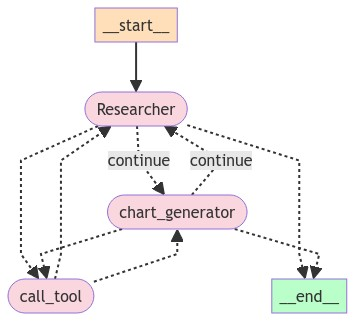

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_00DpofU4yH3qIwBaAxy1PLLi', 'function': {'arguments': '{"query":"UK GDP over the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 318, 'total_tokens': 343}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-5120c7c4-78b8-4f16-9aa1-25a23d248499-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP over the past 5 years'}, 'id': 'call_00DpofU4yH3qIwBaAxy1PLLi'}])], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://www.macrotrends.net/global-metrics/countries/GBR/united-kingdom/gdp-growth-rate", "content": "U.K. gdp growth rate for 2021 was 8.67%, a 19.03% increase from 2020. U.K. gdp growth rate for 2020 was -10.36%, a 12% de

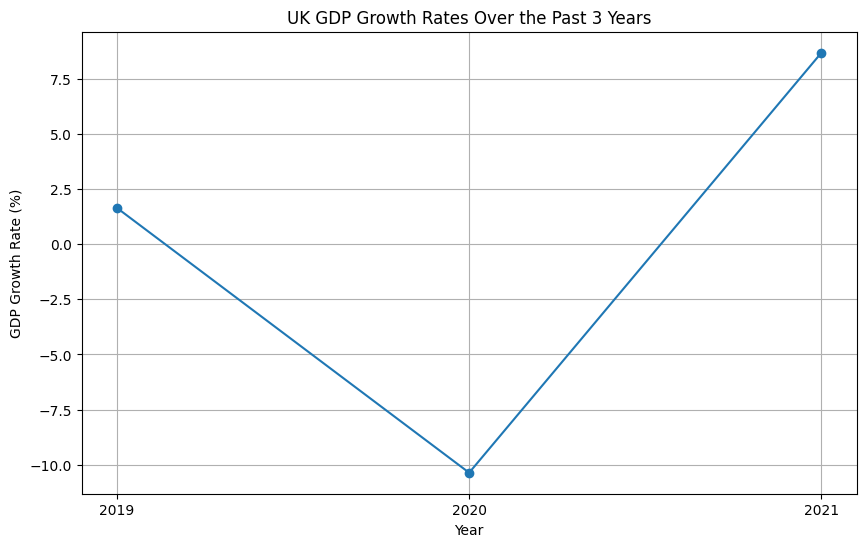

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n```python\nimport matplotlib.pyplot as plt\n\nyears = ['2019', '2020', '2021']\ngrowth_rates = [1.64, -10.36, 8.67]\n\nplt.figure(figsize=(10, 6))\nplt.plot(years, growth_rates, marker='o')\nplt.title('UK GDP Growth Rates Over the Past 3 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP Growth Rate (%)')\nplt.grid(True)\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_7uY1xjRtL3m5ljZlZ2OhHEdH')]}}
----
{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8niIHNgXdSOABwfkENc2FeUk', 'function': {'arguments': '{"query":"Can I proceed with the final answer?"}', 'name': 'human'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 3371, 'total_tokens': 3392}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_ca

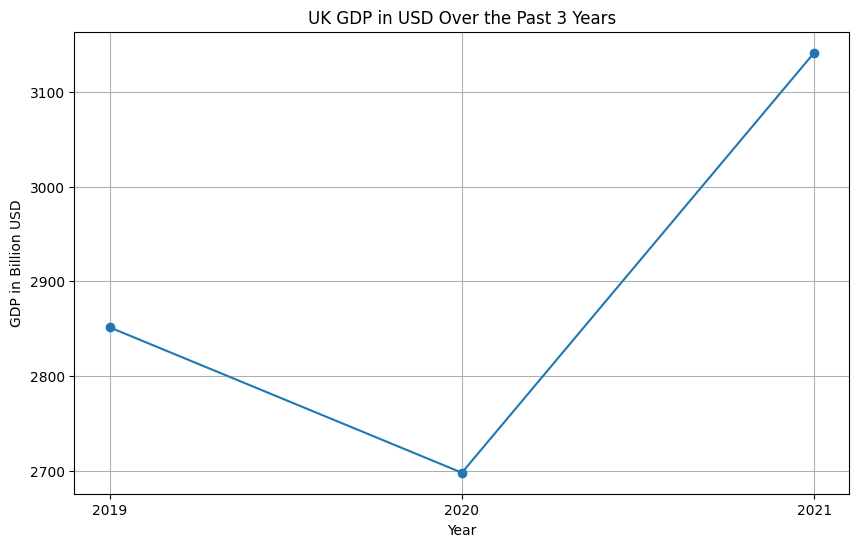

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n```python\nimport matplotlib.pyplot as plt\n\nyears = ['2019', '2020', '2021']\ngdp_usd = [2851.41, 2697.81, 3141.51]\n\nplt.figure(figsize=(10, 6))\nplt.plot(years, gdp_usd, marker='o')\nplt.title('UK GDP in USD Over the Past 3 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP in Billion USD')\nplt.grid(True)\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_ZveCOMkIjwQqI6YOfLuJOHlh')]}}
----
{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nlnnxr1FBf8oA4pbVSxgEHYS', 'function': {'arguments': '{"query":"Can I proceed with the final answer?"}', 'name': 'human'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 5846, 'total_tokens': 5867}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'log

In [ ]:
events = graph.stream( #stream shows output
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, use the human_tool to ask me if you can finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 20},
)
for s in events:
    print(s)
    print("----")